# Aprendizado de máquina - trabalho prático 2
### Danilo Barros Cardoso

Este notebook irá detalhar e demonstrar a implementação do algoritmo de Boosting, bem como a análise de algumas caracteristicas do algoritmo.

Conforme solicitado na especificação do trabalho, não será utilizado nenhuma biblioteca de aprendizado de máquina. Além das classes padrão do Python, será utilizada a biblioteca NumPy para auxiliar no tratamento de algumas operações em listas (como ordenação) e para facilitar algumas operações que precisam ser repetidas para todos os elementos do dataset, por exemplo. 

In [1]:
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## Leitura dos dados

O trecho de código abaixo é responsável apenas pela leitura do arquivo de dados. Trata-se de um arquivo CSV sendo que as 9 primeiras colunas representam posições no tabuleiro do "jogo da velha" e a última coluna representa a o resultado do jogo, recebendo o valor 'positive' caso ao final o jogador 'x' tenha vencido a partida e 'negative' caso ao final o jogador 'o' tenha vencido a partida.

Cada coluna de dados pode receber 3 valores sendo:
<ul>
<li>'x' - Caso a posição esteja ocupada pelo jogador 'x'</li>
<li>'o' - Caso a posição esteja ocupada pelo jogador 'o'</li>
<li>'b' - Caso a posição ainda não tenha sido ocupada por nenhum jogador.</li>
</ul>

Os dados de entrada são armazenados no objeto 'data' como uma lista de listas. Os valores categóricos ('x', 'o', 'b') são mantidos como são. Já os rótulos são armazenados no objeto 'labels' como uma lista. Para se adequar ao algoritmo boosting, os valores dos rótulos são mapeados para os valores +1 (caso o rótulo original seja 'positive') e -1 (caso o rótulo original seja 'negative).

In [2]:
data = []   # Recebe os dados de entrada
labels= []  # Recebe os rótulos mapeandos para os valores +1 e -1 (conforme definido pelo algoritmo Boosting)

with open('tic-tac-toe.data') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        data.append(row[0:9])
        if (row[9] == 'positive'):
            labels.append(1)
        else:
            labels.append(-1)
            

## Stumps

Stumps (ou tocos) são modelos de predição muito simples, construído basicamente como uma única classificação binária aplicada sobre apenas uma característica do conjunto de dados. O AdaBoost é uma composição de vários stumps, construido de forma iterativa, cada um com um peso na predição final calculado a partir da sua acurácia individual.

Os métodos abaixo são responsáveis por:

### list_stump

Dado uma lista de valores categóricos e o número de colunas presentes no dataset, gerar todos os stumps possíveis. Por uma questão de simplicidade, aqui está sendo considerado que todas as colunas do conjunto de dados de entrada irão receber valores pertentes a mesma categoria (no caso do problema do jogo da velha, o valores 'x', 'o', 'b').

A saída desta função é uma lista dos stumps possíveis considerando a decisão pelo valor 'verdadeiro' da categoria (se 'x' então true) e o valor 'negado' da categoria (se 'x' então false). Com isso, para o problema do tic-tac-toe, são gerado 56 stumps.

### predict_stump

Esta função tem por objetivo gerar classificações baseada em apenas um stump. Recebe como entrada o stump e os dados e faz a classificação.

Na saída a função entrega uma lista com as predições através dos valores +1 (positivo) e -1 (negativo)

### stump_misses

O objetivo desta função é identificar os exemplos que o stump recebido como parâmentro classifica incorretamente. Para isso, além do stump, a funão também recebe os dados de treinamento e os rótulos. Com isto ele faz a classificação e compara com os rótulos para encontrar os exemplos incorretamente classificados. A AdaBoost atribui um peso a cada exemplo. Esta função ainda não se preocupa em avaliar os pesos de cada exemplo de entrada, apenas identificar os exemplos que foram incorretamente classificados.

Na saída a função entrega uma lista dos indices dos exemplos que foram incorretamente classíficados.

### stump_error

O objetivo desta função é calcular o erro total do stump (para poder comparar o stump de entrada com outras alternativas). Nesta função os pesos atribuídos a cada exemplo são levados em consideração.

Na saída a função entrega o erro do stump, ponderando os exemplos incorretamente classificados pelos seus respectivos pesos. 





In [15]:
def list_stumps(categories, num_features=9):
    stumps = []
    for f in range(num_features):
        for c in categories:
            stumps.append((f,c, 1)) # É analisado se a caracterirstica é igual
            stumps.append((f,c, -1)) # É analisada se a caracteristica é diferente
    stumps.append(('T',0,0))
    stumps.append(('F',0,0))
    return stumps

def predict_stump(data, stump):
    feature = stump[0]
    if feature == 'T': # Trata a situação do stump apenas classificar todos os exemplos como positivo
        out = []
        for i in range(len(data)):
            out.append(1)
        return out
    
    if feature == 'F': # Trata a situação do stump apenas classificar todos os exemplos como negativo
        out = []
        for i in range(len(data)):
            out.append(-1)
        return out
    
    # Obtem o valor de referência do stump e realiza a classificação
    value = stump[1]
    sign = stump[2]
    out = []
    for i in range(len(data)):
        if (data[i][feature] == value):
            out.append(1*sign)
        else:
            out.append(-1*sign)
    return out

def stump_misses(data, labels, stump):
    preds = predict_stump(data, stump)
    errors = []
    
    for idx, label in enumerate(labels):
        if label != preds[idx]:
            errors.append(idx)
            
    return errors
    
def stump_error(misses, weigths):
    error = 0
    for idx in misses:
        error += weigths[idx]
    return error


In [19]:
# Alguns dados de teste para avaliar os métodos. Dados não relacionados ao problema do jogo da velha

weights_t = np.array([0.7, 0.3])
data_t = [['1', '0', '1'], ['1', '1', '0']]
label_t = [1, -1]
categories_t = ['0', '1']

print('Stumps gerados com os dados de teste das funções')
print(list_stumps(categories_t, num_features=3))

print('\nVerificando erros de classificação para alguns cenários\n')
print('Incorretos:  {} \t Erro: {}'.format(
    stump_misses(data_t, label_t, (0, '1', 1)),
    stump_error(stump_misses(data_t, label_t, (0, '1', 1)), weights_t)
))
print('Incorretos:  {} \t Erro: {}'.format(
    stump_misses(data_t, label_t, (1, '1', 1)),
    stump_error(stump_misses(data_t, label_t, (1, '1', 1)), weights_t)
))
print('Incorretos:  {} \t Erro: {}'.format(
    stump_misses(data_t, label_t, (2, '1', 1)),
    stump_error(stump_misses(data_t, label_t, (2, '1', 1)), weights_t)
))
print('Incorretos:  {} \t Erro: {}'.format(
    stump_misses(data_t, label_t, (2, '1', -1)),
    stump_error(stump_misses(data_t, label_t, (2, '1', -1)), weights_t)
))
print('Incorretos:  {} \t Erro: {}'.format(
    stump_misses(data_t, label_t, ('T', 0, 0 )),
    stump_error(stump_misses(data_t, label_t, ('T', 0, 0 )), weights_t)
))


Stumps gerados com os dados de teste das funções
[(0, '0', 1), (0, '0', -1), (0, '1', 1), (0, '1', -1), (1, '0', 1), (1, '0', -1), (1, '1', 1), (1, '1', -1), (2, '0', 1), (2, '0', -1), (2, '1', 1), (2, '1', -1), ('T', 0, 0), ('F', 0, 0)]

Verificando erros de classificação para alguns cenários

Incorretos:  [1] 	 Erro: 0.3
Incorretos:  [0, 1] 	 Erro: 1.0
Incorretos:  [] 	 Erro: 0
Incorretos:  [0, 1] 	 Erro: 1.0
Incorretos:  [1] 	 Erro: 0.3


## AdaBoost


O algoritmo AdaBoost foi implementado de acordo com o material das aulas. Os seguintes passos são seguindos pelo algoritmo:

<ol>
    <li>Inicializo os pesos
    <li>LOOP:
    <li>&nbsp;&nbsp;&nbsp;Escolho o stump com o menor erro empirico na iteração T
    <li>&nbsp;&nbsp;&nbsp;Calculo o peso do classificador (alfa)
    <li>&nbsp;&nbsp;&nbsp;Atualizo o peso dos dados de teste
    <li>Até completar o número de iterações definido como parâmetro
</ol>

Além da função 'fit' responsável pelo treinamento do modelo, a classe também implementa a função 'predict' que, com os stumps selecionado para o modelo e seus pesos, faz as predições e a função 'calc_accuracy' que, recebendo dados de teste, faz as predições e compara com os rótulos para obter a acurácia do modelo.

Apenas para validar o algoritmo, foi criado o dataset utilizado nas aulas para a validação.

In [20]:
def sort_key(v):
    return v[1]

class CategoricalBoosting:
    def __init__(self, categories = ['x', 'o', 'b'], num_iter = None, verbose = False):
        self.model = None
        self.categories = categories
        self.num_iter = num_iter
        self.verbose = verbose
        
    
    def fit(self, data, labels):
        weights = np.ones(len(data))/len(data)
        stumps = list_stumps(self.categories, num_features=len(data[0]))
        closed_set = set()
        if not self.num_iter:
            self.num_iter = len(stumps)
            
        model = []
        for t in range(self.num_iter):
            error_per_stump = []

            for stump in stumps:
                # if stump not in closed_set:
                misses = stump_misses(data, labels, stump)
                # print(misses)
                error = stump_error(misses, weights)
                error_per_stump.append( (stump, error) )
            error_per_stump.sort(key=sort_key)
            # print('error_per_stump')
            # print(error_per_stump)
            selected_stump = error_per_stump[0][0]
            selected_error = error_per_stump[0][1]
            

            alpha = 0.5 * np.log( (1 - selected_error)/selected_error )
            out = predict_stump(data, selected_stump)
            # print(weights)
            if self.verbose:
                print('Interação: {} \t Stump: {}  \t Erro: {} \t Alpha: {}'.format(t, selected_stump, selected_error, alpha) )

            new_weights = weights * np.exp(-alpha * np.array(out) * np.array(labels))

            weights = new_weights / new_weights.sum() # Normalização
            model.append( (alpha, selected_stump) )
            closed_set.add(selected_stump)
            

        self.model = model
        
    def predict(self, data):
        out = np.zeros(len(data))
        for alpha_stump in self.model:
            h = alpha_stump[0] * np.array(predict_stump(data, alpha_stump[1]))
            out = out + h
        
        for i in range(len(out)):
            if out[i] >=0:
                out[i] = 1
            else:
                out[i] = -1
        return out
    
    def calc_accuracy(self, data, labels):
        preds = self.predict(data)

        errors = np.abs(preds - np.array(labels))/2
        loss = errors.sum() / len(errors)
        return 1 - loss

        
        
    

In [21]:
# Pequeno dataset para testar a implementação
vampires_dataset = {
    'labels': [1,1,1,1,1,1,1,-1,-1,-1],
    'data': [
                ['N', 'Y', 'Y'],
                ['Y', 'Y', 'Y'],
                ['Y', 'N', 'N'],
                ['Y', 'N', 'Y'],
                ['Y', 'N', 'Y'],
                ['N', 'Y', 'Y'],
                ['N', 'Y', 'Y'],
                ['N', 'Y', 'N'],
                ['Y', 'N', 'N'],
                ['N', 'N', 'Y'],
            ],
    'categories': ['N', 'Y']
}

model =  CategoricalBoosting(categories=vampires_dataset['categories'], num_iter=4, verbose=True)

model.fit(vampires_dataset['data'], vampires_dataset['labels'])

acc = model.calc_accuracy(vampires_dataset['data'], vampires_dataset['labels'])

print('Acurácia = {}'.format(acc))

Interação: 0 	 Stump: (2, 'N', -1)  	 Erro: 0.2 	 Alpha: 0.6931471805599453
Interação: 1 	 Stump: (0, 'N', -1)  	 Erro: 0.25 	 Alpha: 0.5493061443340549
Interação: 2 	 Stump: (1, 'N', -1)  	 Erro: 0.29166666666666663 	 Alpha: 0.44365159750045147
Interação: 3 	 Stump: ('T', 0, 0)  	 Erro: 0.27731092436974786 	 Alpha: 0.4789198673935139
Acurácia = 0.8


## Treinando e validando o modelo

Para fazer o treinamento e para verificar a qualidade do modelo está sendo utilizado a validação cruzada. Nos experimentos, por padrão, está sendo utilizada a validação com 5 folds.

In [22]:
class CrossValidation():
    def __init__(self, data, labels, folds=5):
        self.folds = folds
        self.data = data
        self.labels = labels
        self.length = len(data)
        self.fold_length = self.length / folds
        self.idx = np.arange(self.length )
        np.random.seed(1000)
        np.random.shuffle(self.idx)
        self.idx = list(self.idx)
        # print(self.idx[0:5])
        
        
    def get_fold(self, fold):
        # Calcula os indices iniciais e finais do fold
        fi = int(np.ceil(fold*self.fold_length))
        ff = int(np.ceil((fold+1)*self.fold_length))
        train_idx = self.idx[:fi] + self.idx[ff:]
        val_idx = self.idx[fi:ff]
        
        # Divide os dados em treino e validação de acordo com o fold
        train_data = [self.data[i] for i in train_idx] 
        train_labels = [self.labels[i] for i in train_idx] 
        
        val_data = [self.data[i] for i in val_idx] 
        val_labels = [self.labels[i] for i in val_idx] 
        
        return train_data, train_labels, val_data, val_labels
        
def run_experiment(data, labels, num_iter = None, verbose=False):     
    folds = 5
    cross = CrossValidation(data, labels, folds=folds)
    fold_accuracy = []

    for i in range(folds):
        train_data, train_labels, val_data, val_labels = cross.get_fold(i)

        model =  CategoricalBoosting(num_iter=num_iter)
        model.fit(train_data, train_labels)
        acc = model.calc_accuracy(val_data, val_labels)
        fold_accuracy.append(acc)
        if verbose:
            print('Acurácia = {}'.format(acc))

    #Para calcular a validação cruzada tiro a média da acurácia de cada fold
    cross_validation_accuracy = np.array(fold_accuracy).sum() / folds
    if verbose:
        print('Validação cruzada: {}'.format(cross_validation_accuracy) )
    return cross_validation_accuracy
        
run_experiment(data, labels, verbose=True)

Acurácia = 0.84375
Acurácia = 0.8802083333333334
Acurácia = 0.8743455497382199
Acurácia = 0.8229166666666666
Acurácia = 0.774869109947644
Validação cruzada: 0.8392179319371728


0.8392179319371728

# Resultados

Para avaliar o desempenho e selecionar o hiperparametro, o treinamento está sendo executado várias vezes. Uma para cada número de stumps. Foram executados 100 experimentos variando o número de estimadores. Como o número de estimadores e maior que o número de stumps possíveis, existe repetição do estimador.

O resultado pode ser visto no gráfico abaixo, mostrando a acurácia para cada um dos valores do parâmetro de número de iterações.

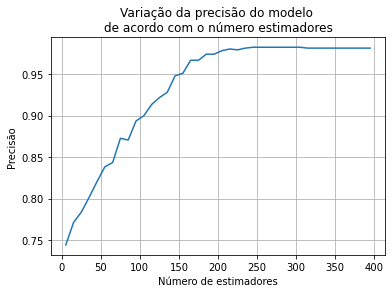

In [30]:
num_iterations = []
accuracies=[]

for i in range(5, 400,10):
    acc = run_experiment(data, labels, num_iter=i)
    num_iterations.append(i)
    accuracies.append(acc)

fig, ax = plt.subplots()
ax.plot(np.array(num_iterations), np.array(accuracies))

ax.set(xlabel='Número de estimadores', ylabel='Precisão',
       title='Variação da precisão do modelo \nde acordo com o número estimadores')
ax.grid()

plt.show()

In [29]:
print('Melhor desempenho {}'.format(np.max(accuracies[-1]) ))

Melhor desempenho 0.981217277486911


Como pode ser visto no gráfico acima, o desempenho cresce com número de estimadores até o limite de aproximadamente 98%. Aumentar a complexidade do modelo não gerou overfitting como era de se esperar.